In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split
from scipy.stats import loguniform
from xgboost import XGBClassifier

Basic Preprocessing

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Student_performance_data _.csv")

print("First few rows of the dataset:")
print(df.head())

print("\nDataset Information:")
print(df.info())

print("\nStatistical Summary of the dataset:")
print(df.describe())


# identify all the numerical and categorical columns

num_cols=df.select_dtypes(include=["float64","int64"]).columns
cat_cols=df.select_dtypes(include=["object"]).columns
if cat_cols.empty:
  print("No categorical columns")
else:
  print("categorical columns are: ", cat_cols)


print("numerical columns are: ", num_cols)


#checking for null values:
print("missing values in each column are:\n ", df.isnull().sum())
if (df.isnull().sum()==0).all():
  print("No missing values")

else:
  df=df.fillna(df.mean())


First few rows of the dataset:
   StudentID  Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
0       1001   17       1          0                  2        19.833723   
1       1002   18       0          0                  1        15.408756   
2       1003   15       0          2                  3         4.210570   
3       1004   17       1          0                  3        10.028829   
4       1005   17       1          0                  2         4.672495   

   Absences  Tutoring  ParentalSupport  Extracurricular  Sports  Music  \
0         7         1                2                0       0      1   
1         0         0                1                0       0      0   
2        26         0                2                0       0      0   
3        14         0                3                1       0      0   
4        17         1                3                0       0      0   

   Volunteering       GPA  GradeClass  
0             0  2.929196  

Plots for better understanding(preprocessing)

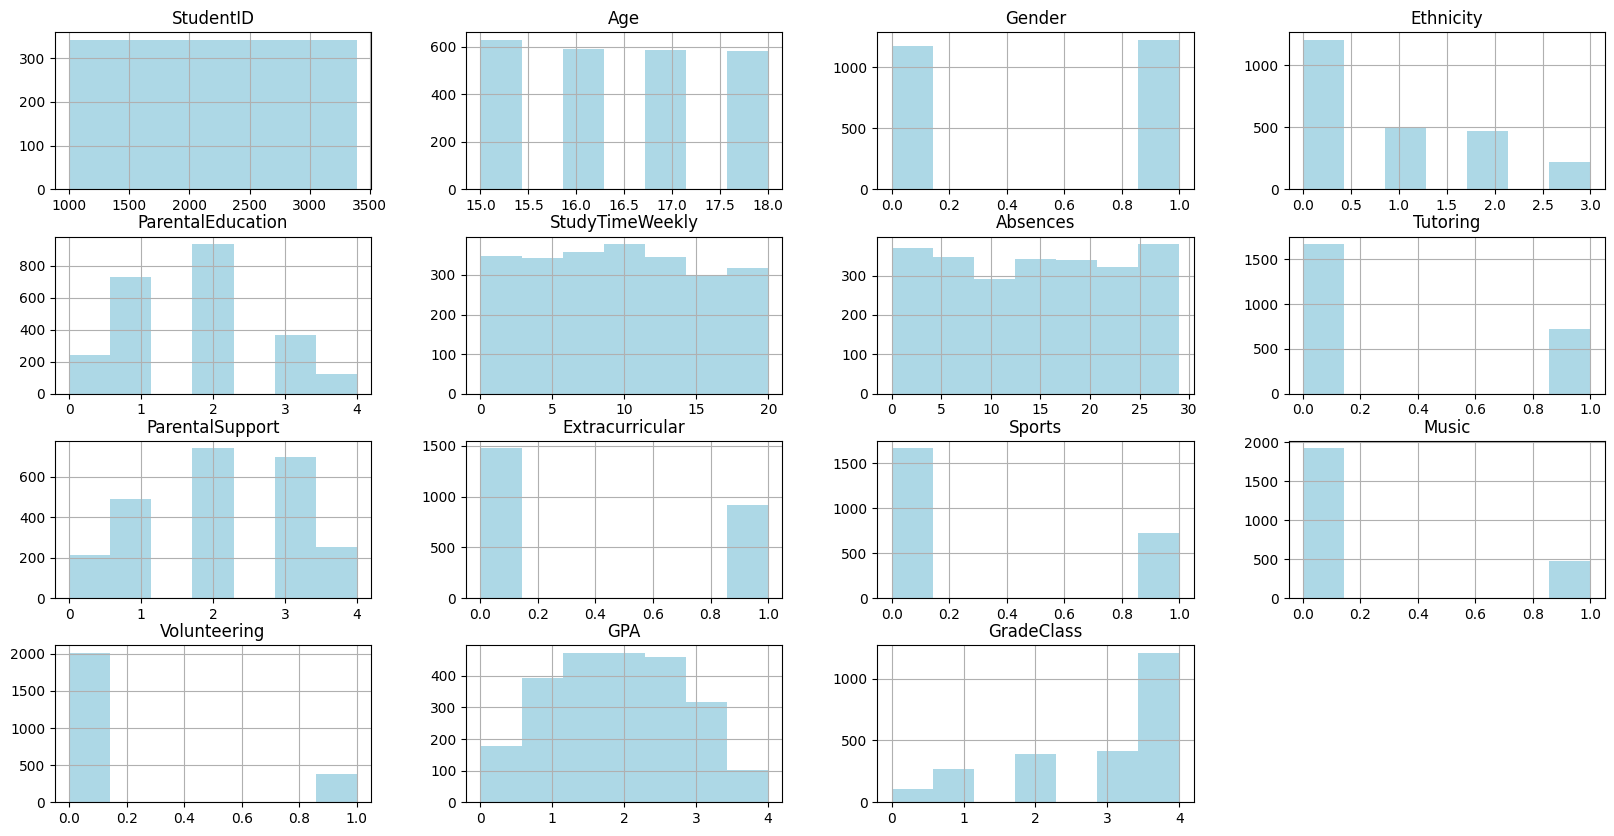

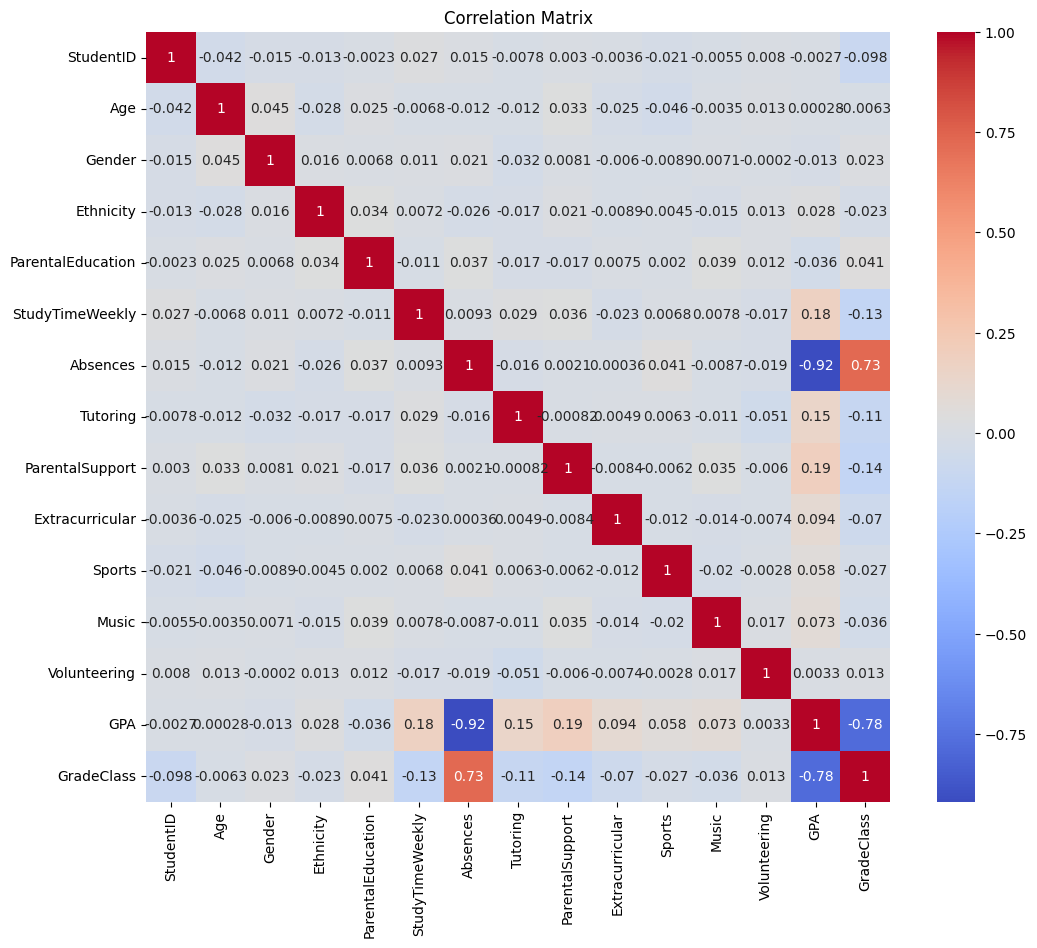

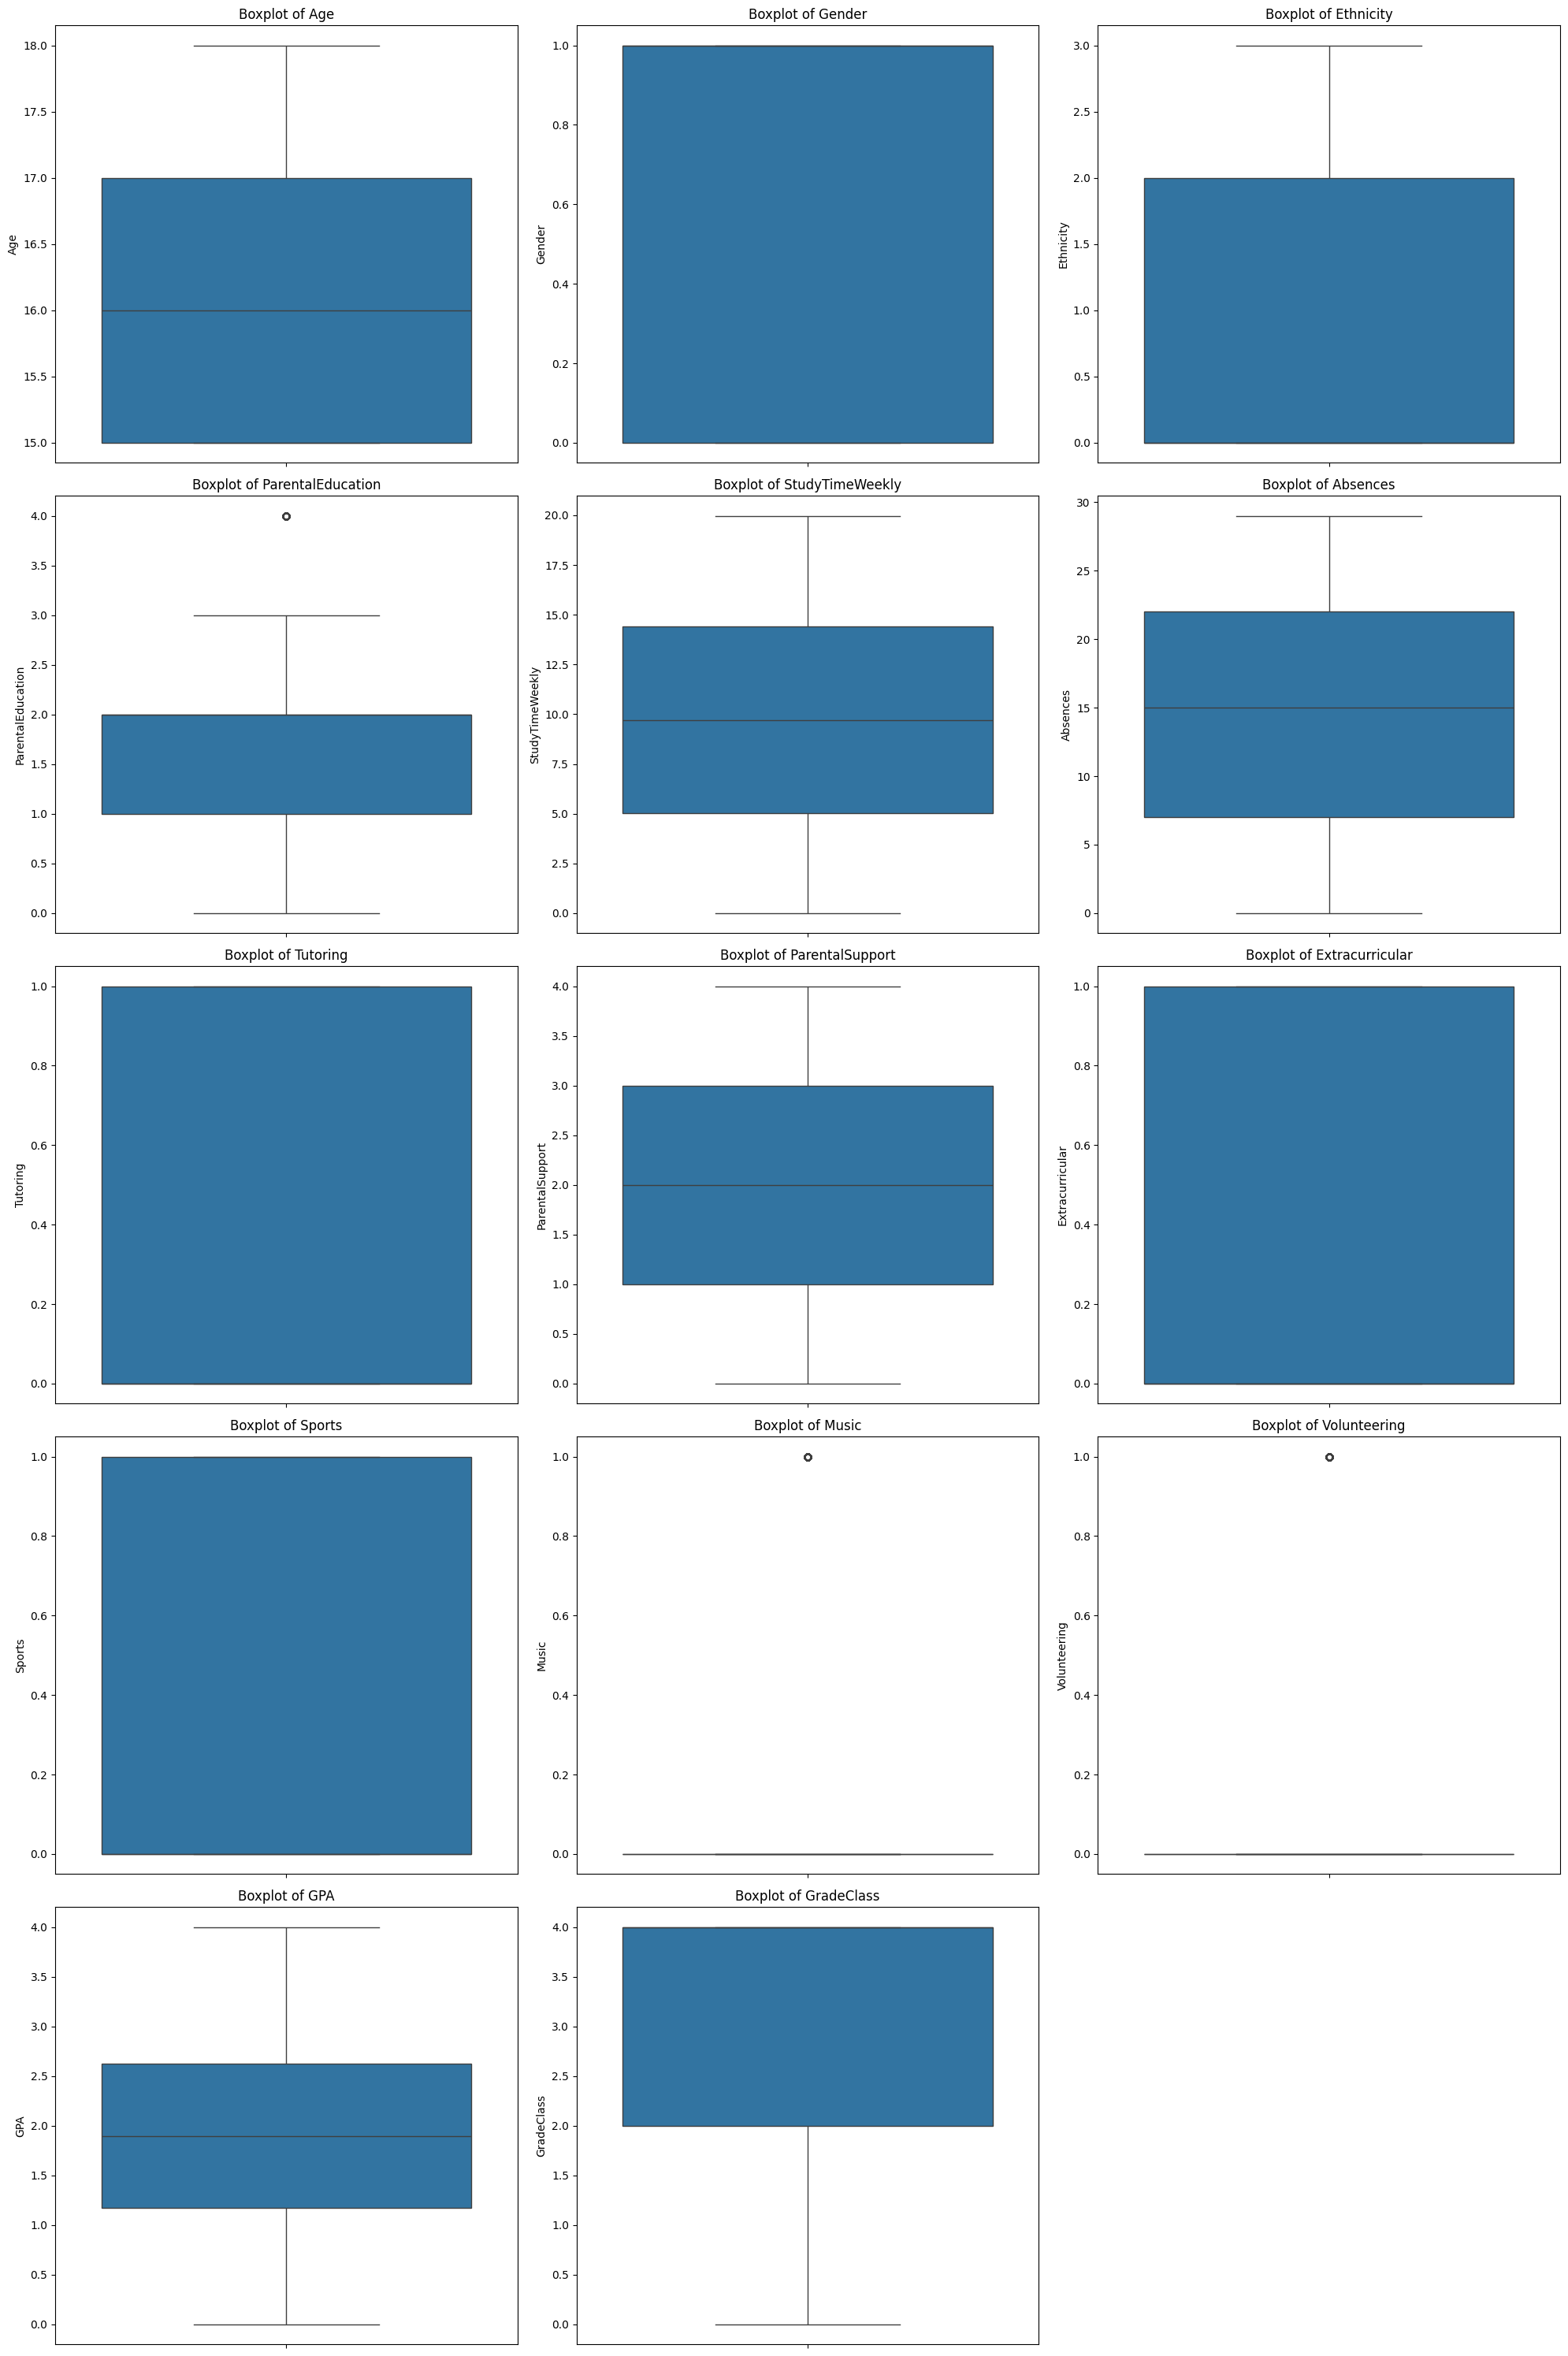

In [ ]:
# plot histograms for numerical features

df.hist(figsize=(20,10),bins=7, color='lightblue')

numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


# Exclude 'StudentID' since it's an identifier
columns_to_plot = df.columns.drop('StudentID')

# Set up the size of the figure to accommodate all columns
plt.figure(figsize=(20, 30))

# Loop through all columns and create subplots for each
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


Note: here grade class classification is given as
GradeClass: Classification of students' grades based on GPA:

0: 'A' (GPA >= 3.5)

1: 'B' (3.0 <= GPA < 3.5)

2: 'C' (2.5 <= GPA < 3.0)

3: 'D' (2.0 <= GPA < 2.5)

4: 'F' (GPA < 2.0)

Hence the we can see inverese (negative) realtion between GradeClass and GPA, but in actual it is positve 0.78
Similarly Absences and GradeCLass have correlation of -0.73

In [ ]:
#scaling the dataset using standard scaler
scaler = StandardScaler()
new_df = df
numeric_columns = ['Age', 'ParentalEducation', 'StudyTimeWeekly', 'Absences', 'ParentalSupport', 'GPA'] # Changed to a single list
new_df[numeric_columns] = scaler.fit_transform(new_df[numeric_columns])
print(new_df.head())

   StudentID       Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
0       1001  0.472919       1          0           0.253711         1.780336   
1       1002  1.362944       0          0          -0.746087         0.997376   
2       1003 -1.307132       0          2           1.253509        -0.984045   
3       1004  0.472919       1          0           1.253509         0.045445   
4       1005  0.472919       1          0           0.253711        -0.902311   

   Absences  Tutoring  ParentalSupport  Extracurricular  Sports  Music  \
0 -0.890822         1        -0.108744                0       0      1   
1 -1.717694         0        -0.999551                0       0      0   
2  1.353542         0        -0.108744                0       0      0   
3 -0.063951         0         0.782063                1       0      0   
4  0.290422         1         0.782063                0       0      0   

   Volunteering       GPA  GradeClass  
0             0  1.118086   

In [ ]:
# Dropping the columns which have minimal correlation with GradeCLass
# Splitting into 80-20 train-test ratio

Y = new_df['GradeClass' ]
X = new_df.drop(columns=['GradeClass' , 'StudentID', 'Volunteering', 'Sports', 'Music'] , axis=1)
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(new_X_train.shape)
print(new_X_test.shape)
print(new_y_train.shape)
print(new_y_test.shape)

(1913, 10)
(479, 10)
(1913,)
(479,)


Feature Importance

<ipython-input-8-062851bd4dee>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=fimp.index, x=fimp.values, orient='h',palette="Set1")


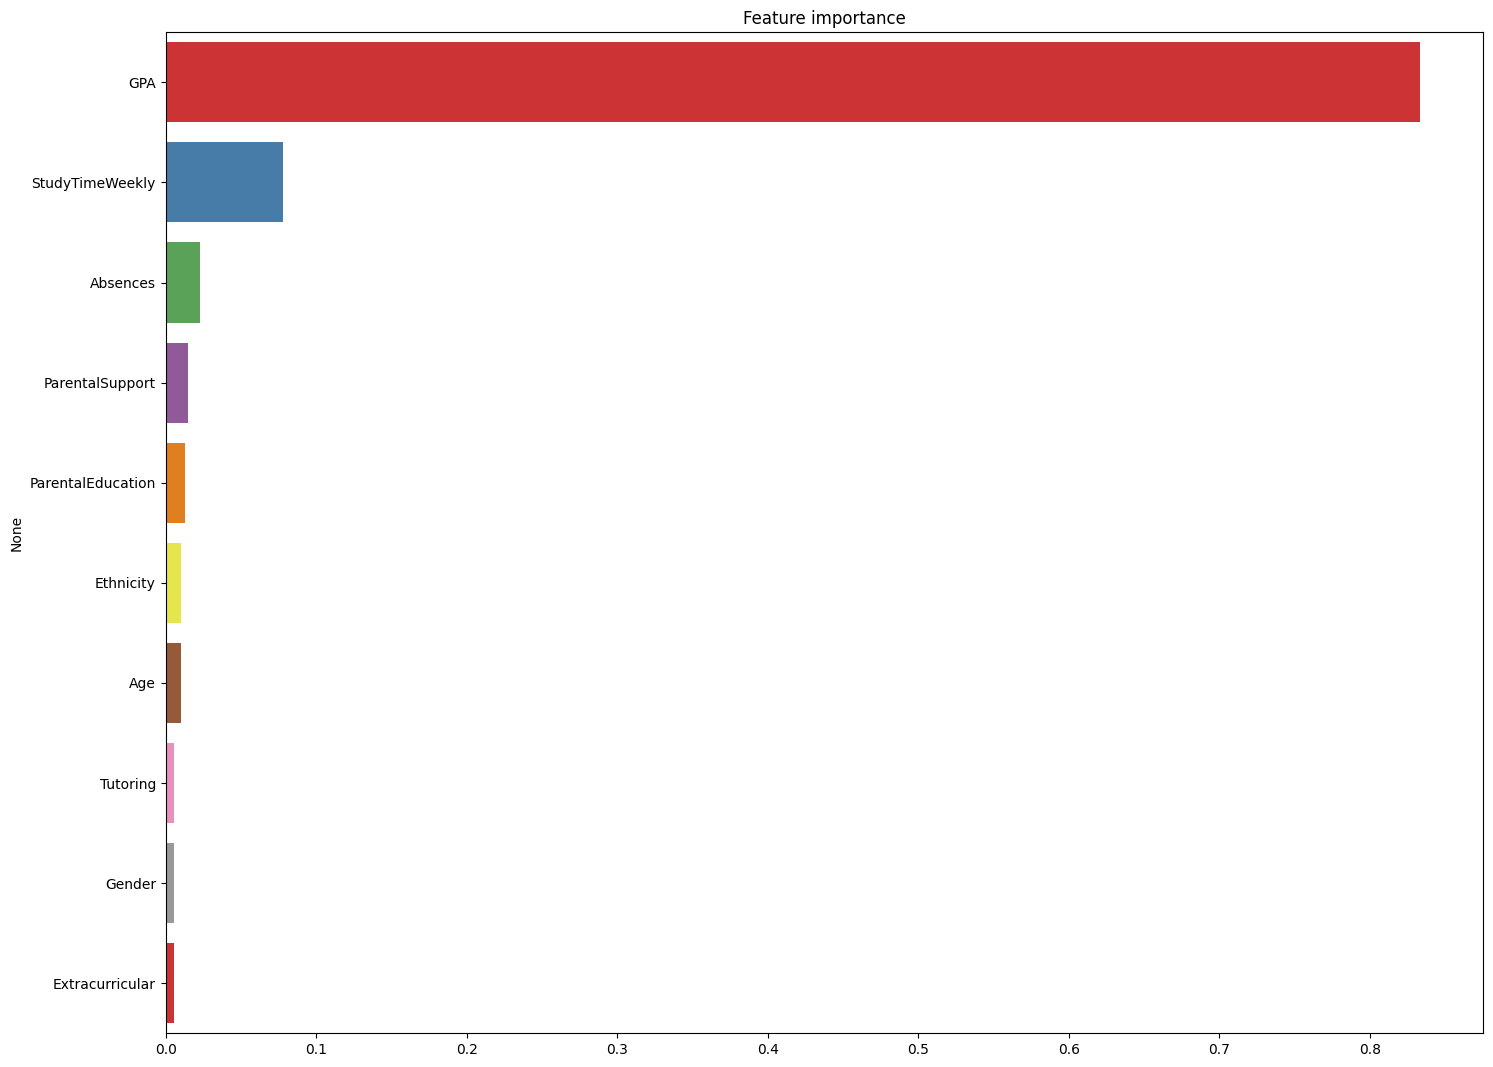

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestRegressor(random_state=42)
clf = clf.fit(X, Y)

fimp = pd.Series(data=clf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(17,13))
plt.title("Feature importance")
ax = sns.barplot(y=fimp.index, x=fimp.values, orient='h',palette="Set1")

In [ ]:
#Checking that the changes have been made
new_X_train.head()

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,GPA
642,1.362944,1,0,2.253308,1.476909,1.117293,1,-1.890357,1,-0.557298
1752,-0.417106,1,3,0.253711,-1.292153,0.526671,0,-0.999551,0,-1.258448
1401,0.472919,0,2,1.253509,-1.117489,1.235418,0,-1.890357,0,-1.934524
2032,0.472919,1,0,-0.746087,1.073350,1.235418,1,-0.108744,0,-0.802211
990,-0.417106,0,0,-1.745885,-1.544099,0.526671,1,-0.108744,0,-0.173591


In [ ]:
new_y_train.head()

,GradeClass
642,4.0
1752,4.0
1401,4.0
2032,4.0
990,4.0


Model accuracies

In [ ]:
#Training the classification models and printing the accuracies
classification_models = {
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(),
}

model_names = []
accuracies = []

# Train and evaluate each model
for name, clf in classification_models.items():
    clf.fit(new_X_train, new_y_train)
    y_pred = clf.predict(new_X_test)
    score = accuracy_score(new_y_test, y_pred)
    model_names.append(name)
    accuracies.append(score)
    print(f"{name} accuracy: {score:.2f}")

# Create a DataFrame for model accuracies
new_df_models = pd.DataFrame({'Model': model_names, 'Accuracy': accuracies})

# Display the model accuracies
print(new_df_models)

import plotly.express as px

# Convert accuracies to percentages (with 2 decimal places)
new_df_models['Accuracy (%)'] = (new_df_models['Accuracy'] * 100).round(2)

# Plot model accuracies using Plotly and show the accuracy on top of each bar
fig = px.bar(new_df_models, x='Model', y='Accuracy', title='Model Accuracies',
             text='Accuracy (%)')

# Customize the text position and format
fig.update_traces(textposition='outside')

# Update the y-axis to show percentage
fig.update_layout(yaxis_tickformat='%')

# Show the plot
fig.show()


K-Nearest Neighbors accuracy: 0.70
Support Vector Machine accuracy: 0.82
Logistic Regression accuracy: 0.75
Decision Tree accuracy: 0.84
Random Forest accuracy: 0.92
Gradient Boosting accuracy: 0.90


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost accuracy: 0.89
Gaussian Naive Bayes accuracy: 0.77
XGBoost accuracy: 0.91
                    Model  Accuracy
0     K-Nearest Neighbors  0.697286
1  Support Vector Machine  0.816284
2     Logistic Regression  0.749478
3           Decision Tree  0.843424
4           Random Forest  0.916493
5       Gradient Boosting  0.903967
6                AdaBoost  0.887265
7    Gaussian Naive Bayes  0.770355
8                 XGBoost  0.906054


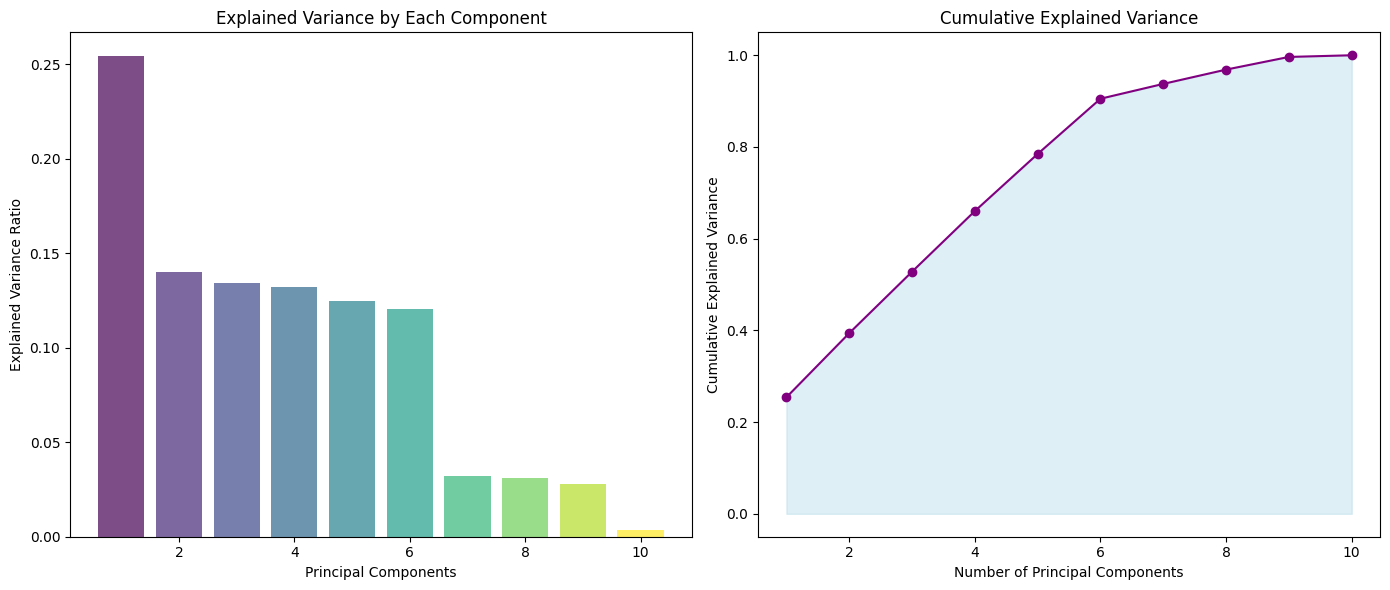

In [ ]:
from sklearn.decomposition import PCA

# Fit PCA to the training data (for visualization purposes only)
pca = PCA().fit(new_X_train)

# Explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Generate colors for each component using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(explained_variance)))

# Create a side-by-side plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot explained variance ratio for each component with multiple colors
ax1.bar(range(1, len(explained_variance) + 1), explained_variance, color=colors, alpha=0.7)
ax1.set_xlabel('Principal Components')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Explained Variance by Each Component')

# Plot cumulative explained variance
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='purple')
ax2.fill_between(range(1, len(cumulative_variance) + 1), 0, cumulative_variance, color='lightblue', alpha=0.4)
ax2.set_xlabel('Number of Principal Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance')

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import plotly.express as px
import pandas as pd

# Apply PCA after standard scaling
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca_train = pca.fit_transform(new_X_train)
X_pca_test = pca.transform(new_X_test)

# Initialize models and storage
classification_models = {
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(),
}

model_names = []
accuracies = []

# Train and evaluate each model on PCA-transformed data
for name, clf in classification_models.items():
    clf.fit(X_pca_train, new_y_train)
    y_pred = clf.predict(X_pca_test)
    score = accuracy_score(new_y_test, y_pred)
    model_names.append(name)
    accuracies.append(score)
    print(f"{name} accuracy after PCA: {score:.2f}")

# Create a DataFrame for model accuracies
new_df_models = pd.DataFrame({'Model': model_names, 'Accuracy': accuracies})

# Display the model accuracies
print(new_df_models)

# Convert accuracies to percentages (with 2 decimal places)
new_df_models['Accuracy (%)'] = (new_df_models['Accuracy'] * 100).round(2)

# Plot model accuracies using Plotly and show the accuracy on top of each bar
fig = px.bar(new_df_models, x='Model', y='Accuracy', title='Model Accuracies after PCA',
             text='Accuracy (%)')

# Customize the text position and format
fig.update_traces(textposition='outside')

# Update the y-axis to show percentage (if desired)
fig.update_layout(yaxis_tickformat='%')

# Show the plot
fig.show()


K-Nearest Neighbors accuracy after PCA: 0.68
Support Vector Machine accuracy after PCA: 0.80
Logistic Regression accuracy after PCA: 0.74
Decision Tree accuracy after PCA: 0.71
Random Forest accuracy after PCA: 0.81
Gradient Boosting accuracy after PCA: 0.79


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



AdaBoost accuracy after PCA: 0.73
Gaussian Naive Bayes accuracy after PCA: 0.75
XGBoost accuracy after PCA: 0.80
                    Model  Accuracy
0     K-Nearest Neighbors  0.684760
1  Support Vector Machine  0.799582
2     Logistic Regression  0.739040
3           Decision Tree  0.705637
4           Random Forest  0.810021
5       Gradient Boosting  0.789144
6                AdaBoost  0.728601
7    Gaussian Naive Bayes  0.745303
8                 XGBoost  0.797495


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Initialize lists to store results
model_names = []
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

# Modify SVC to include probability
classification_models["Support Vector Machine"] = SVC(probability=True)

# Evaluate each model
for name, clf in classification_models.items():
    clf.fit(new_X_train, new_y_train)
    y_pred = clf.predict(new_X_test)

    # Calculate metrics
    accuracy = accuracy_score(new_y_test, y_pred)
    precision = precision_score(new_y_test, y_pred, average='weighted')
    recall = recall_score(new_y_test, y_pred, average='weighted')
    f1 = f1_score(new_y_test, y_pred, average='weighted')

    # Calculate ROC-AUC if possible
    try:
        if len(set(new_y_test)) == 2:  # Binary classification
            roc_auc = roc_auc_score(new_y_test, clf.predict_proba(new_X_test)[:, 1])
        else:  # Multiclass
            roc_auc = roc_auc_score(new_y_test, clf.predict_proba(new_X_test), multi_class='ovr')
    except AttributeError:
        roc_auc = None  # Set to None if `predict_proba` isn't available

    # Append results to lists
    model_names.append(name)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)

    # Print classification report for each model
    print(f"Classification Report for {name}:\n", classification_report(new_y_test, y_pred))

# Create DataFrame for easy comparison
metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'ROC-AUC': roc_aucs
})

# Display the metrics DataFrame
print(metrics_df)


Classification Report for K-Nearest Neighbors:
               precision    recall  f1-score   support

         0.0       0.56      0.23      0.32        22
         1.0       0.37      0.45      0.40        49
         2.0       0.50      0.48      0.49        85
         3.0       0.57      0.50      0.53        86
         4.0       0.88      0.94      0.91       237

    accuracy                           0.70       479
   macro avg       0.57      0.52      0.53       479
weighted avg       0.69      0.70      0.69       479

Classification Report for Support Vector Machine:
               precision    recall  f1-score   support

         0.0       1.00      0.09      0.17        22
         1.0       0.62      0.76      0.68        49
         2.0       0.81      0.69      0.75        85
         3.0       0.71      0.78      0.74        86
         4.0       0.90      0.95      0.93       237

    accuracy                           0.82       479
   macro avg       0.81      0.6

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Classification Report for AdaBoost:
               precision    recall  f1-score   support

         0.0       0.75      0.14      0.23        22
         1.0       0.68      0.88      0.77        49
         2.0       0.92      0.84      0.88        85
         3.0       0.88      0.88      0.88        86
         4.0       0.93      0.98      0.95       237

    accuracy                           0.89       479
   macro avg       0.83      0.74      0.74       479
weighted avg       0.89      0.89      0.88       479

Classification Report for Gaussian Naive Bayes:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        22
         1.0       0.60      0.65      0.63        49
         2.0       0.68      0.78      0.73        85
         3.0       0.60      0.70      0.65        86
         4.0       0.92      0.89      0.91       237

    accuracy                           0.77       479
   macro avg       0.56      0.60      0.58  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Classification Report for XGBoost:
               precision    recall  f1-score   support

         0.0       0.81      0.59      0.68        22
         1.0       0.86      0.86      0.86        49
         2.0       0.92      0.85      0.88        85
         3.0       0.85      0.90      0.87        86
         4.0       0.94      0.97      0.95       237

    accuracy                           0.91       479
   macro avg       0.88      0.83      0.85       479
weighted avg       0.91      0.91      0.90       479

                    Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0     K-Nearest Neighbors  0.697286   0.691175  0.697286  0.689827  0.831309
1  Support Vector Machine  0.816284   0.827685  0.816284  0.802512  0.917966
2     Logistic Regression  0.749478   0.714032  0.749478  0.728252  0.892948
3           Decision Tree  0.832985   0.837038  0.832985  0.833235  0.862169
4           Random Forest  0.920668   0.919915  0.920668  0.918836  0.921391
5       Gradi

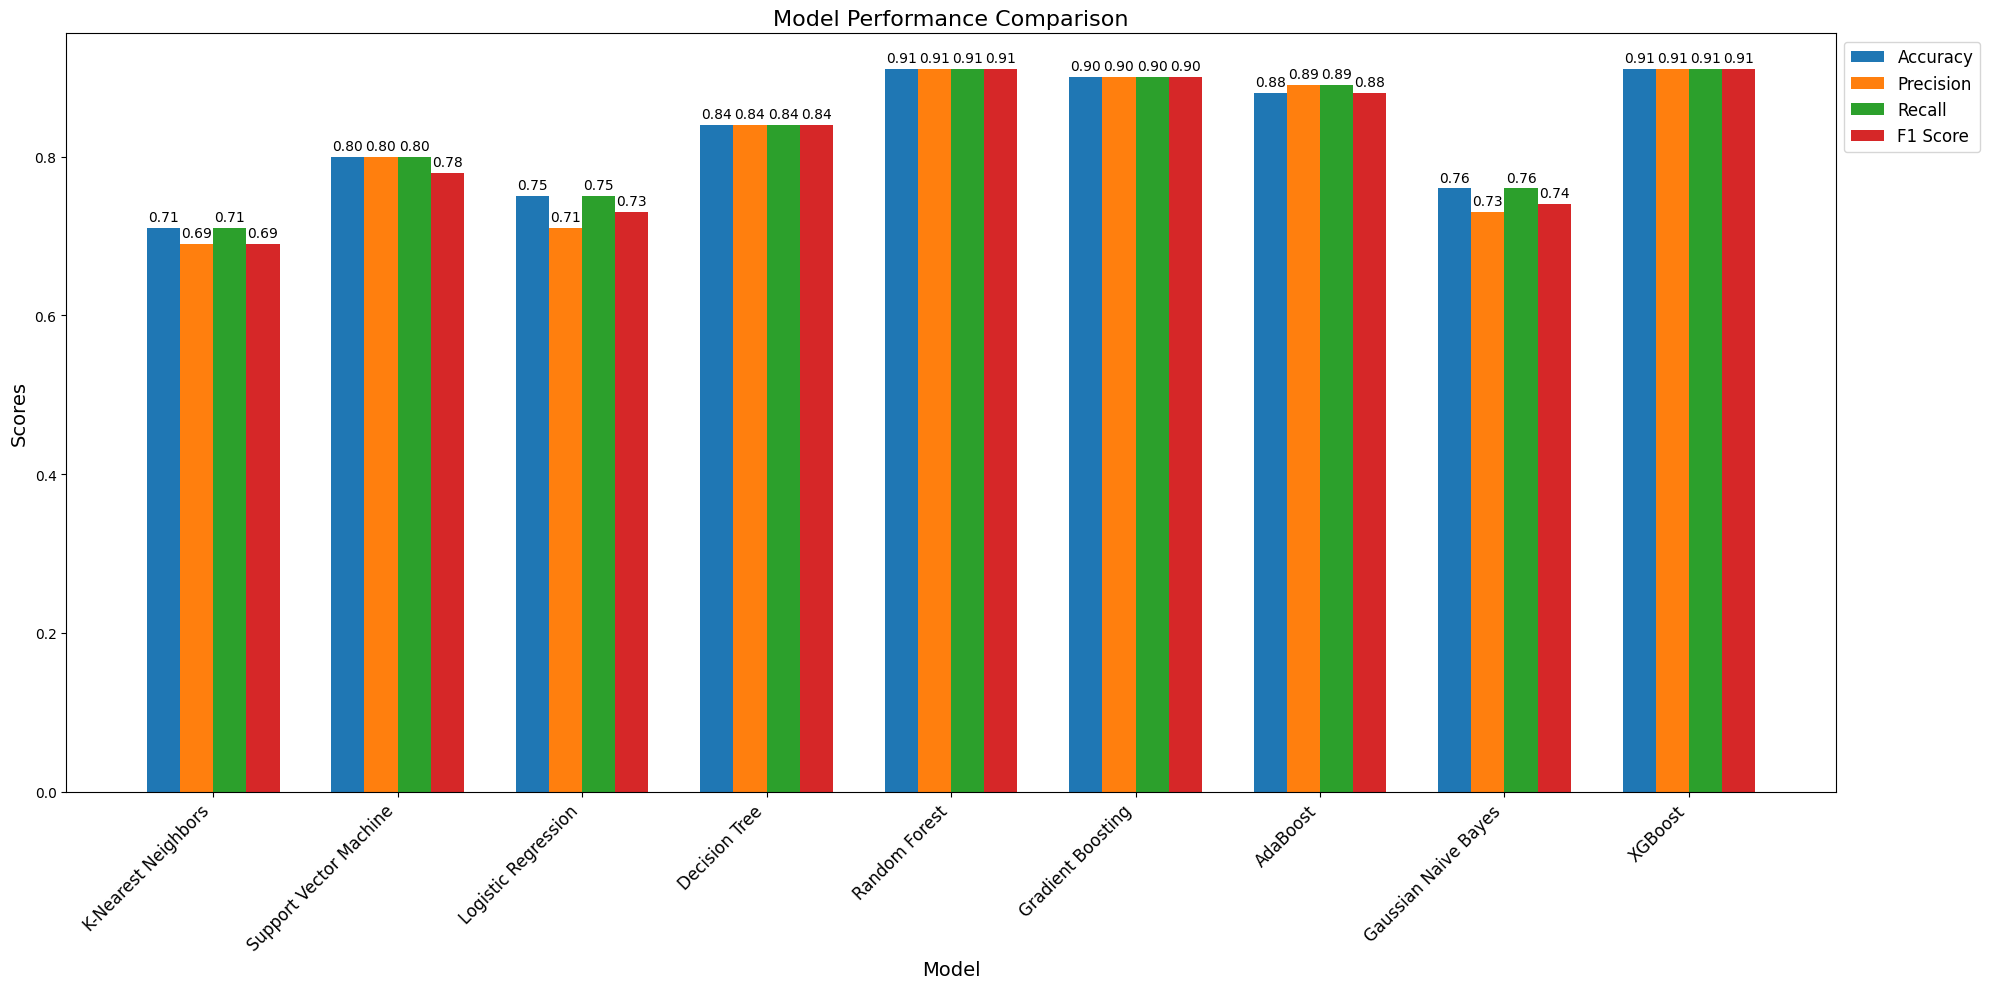

In [ ]:
# Sample Data (assuming `metrics_df` is your DataFrame)
metrics_df = pd.DataFrame({
    'Model': ['K-Nearest Neighbors', 'Support Vector Machine', 'Logistic Regression', 'Decision Tree',
              'Random Forest', 'Gradient Boosting', 'AdaBoost', 'Gaussian Naive Bayes', 'XGBoost'],
    'Accuracy': [0.71, 0.80, 0.75, 0.84, 0.91, 0.90, 0.88, 0.76, 0.91],
    'Precision': [0.69, 0.80, 0.71, 0.84, 0.91, 0.90, 0.89, 0.73, 0.91],
    'Recall': [0.71, 0.80, 0.75, 0.84, 0.91, 0.90, 0.89, 0.76, 0.91],
    'F1 Score': [0.69, 0.78, 0.73, 0.84, 0.91, 0.90, 0.88, 0.74, 0.91]
})

# Set figure size
plt.figure(figsize=(20, 10))

# Set bar width and positions
bar_width = 0.18
index = np.arange(len(metrics_df))

# Define colors for each metric
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot each metric with model names as x-ticks
plt.bar(index, metrics_df['Accuracy'], bar_width, label='Accuracy', color=colors[0])
plt.bar(index + bar_width, metrics_df['Precision'], bar_width, label='Precision', color=colors[1])
plt.bar(index + 2 * bar_width, metrics_df['Recall'], bar_width, label='Recall', color=colors[2])
plt.bar(index + 3 * bar_width, metrics_df['F1 Score'], bar_width, label='F1 Score', color=colors[3])

# Add scores above each bar
for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score']):
    for j, value in enumerate(metrics_df[metric]):
        plt.text(j + i * bar_width, value + 0.005, f"{value:.2f}", ha='center', va='bottom', fontsize=10)

# Add labels, title, and improve font sizes
plt.xlabel('Model', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Model Performance Comparison', fontsize=16)
plt.xticks(index + 1.5 * bar_width, metrics_df['Model'], rotation=45, ha='right', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

plt.tight_layout()
plt.show()


ROC & AUC plot

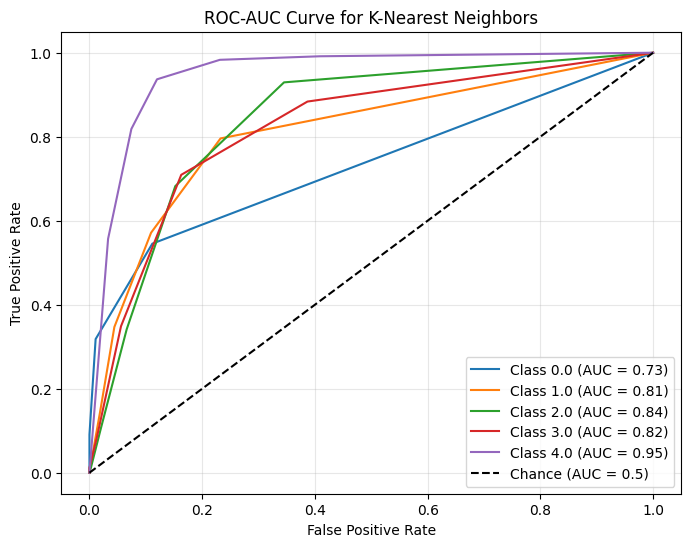

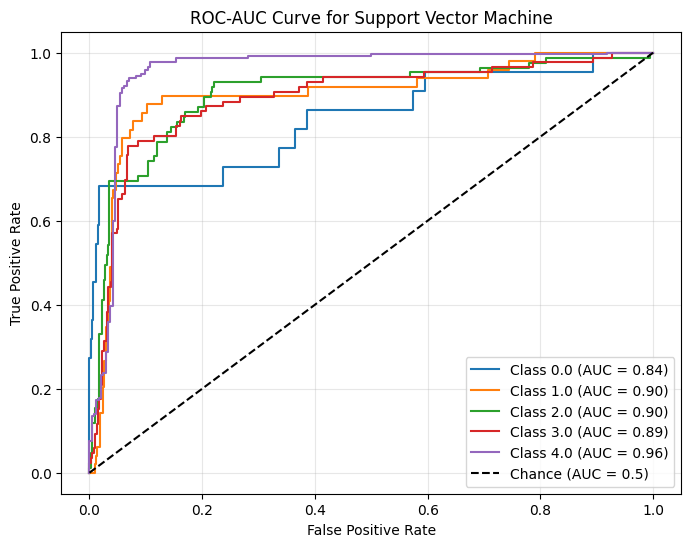

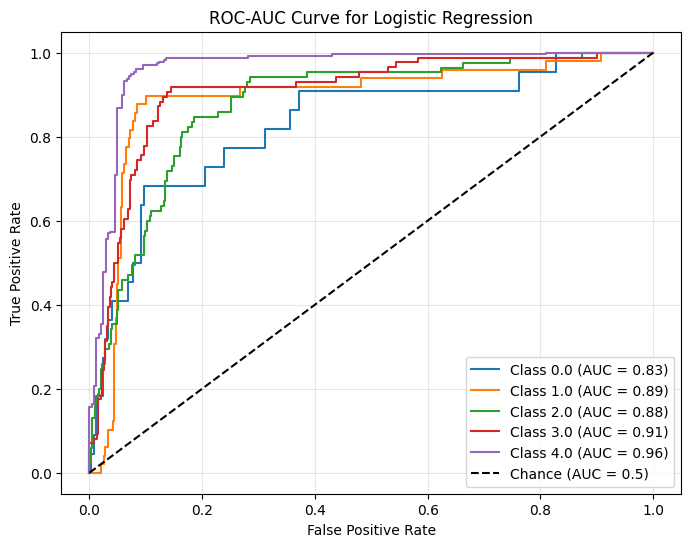

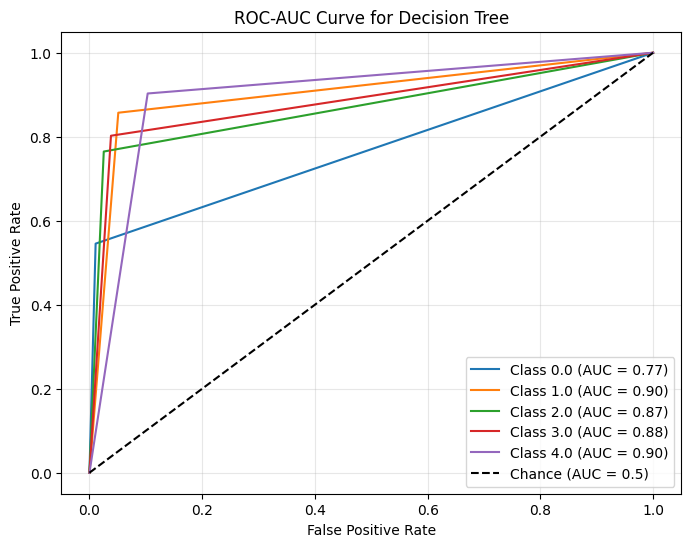

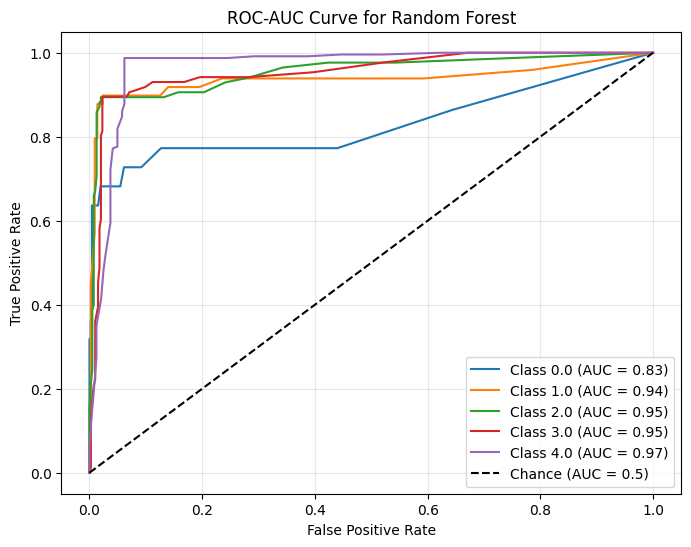

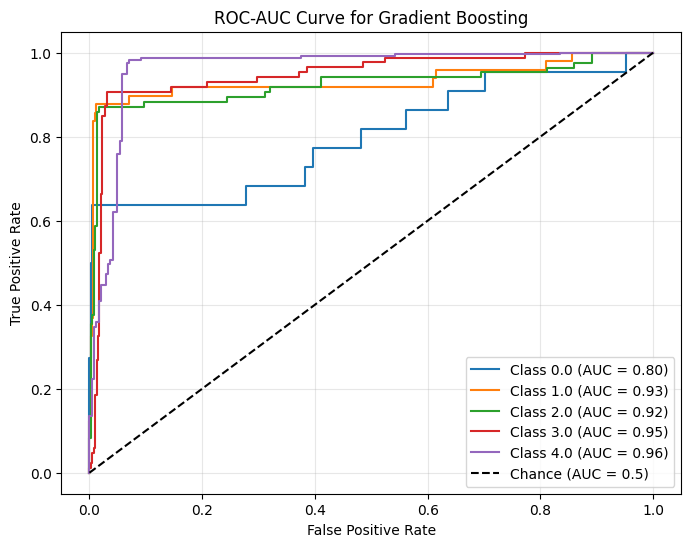

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



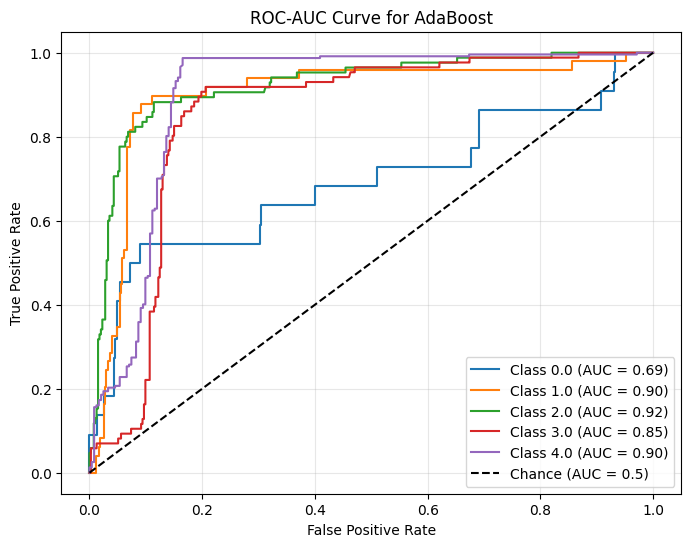

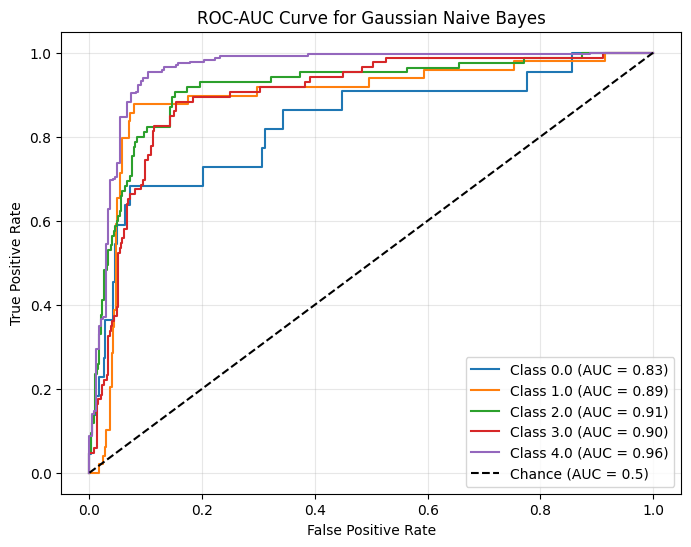

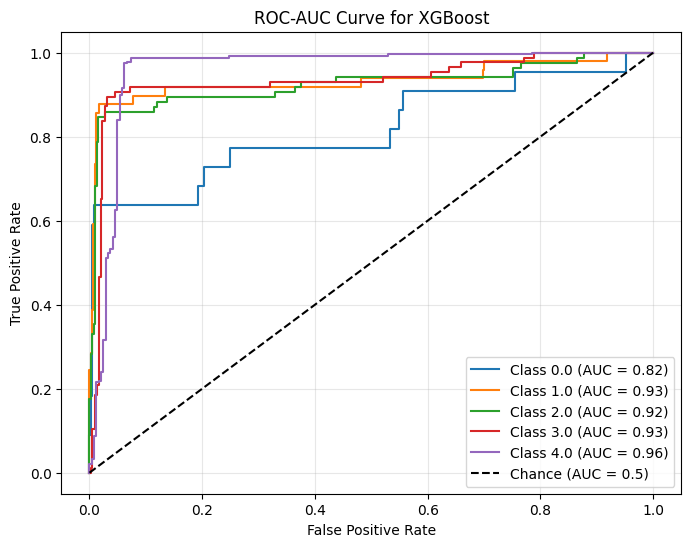

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output if it's multiclass
classes = np.unique(new_y_test)
if len(classes) > 2:
    y_test_binarized = label_binarize(new_y_test, classes=classes)
else:
    y_test_binarized = new_y_test

# Loop through each model to create a separate plot
for name, model in classification_models.items():
    model.fit(new_X_train, new_y_train)

    # Check if the model has probability scores or decision function
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(new_X_test)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(new_X_test)
    else:
        continue  # Skip models without `predict_proba` or `decision_function`

    plt.figure(figsize=(8, 6))

    # Calculate ROC curve and ROC-AUC for each class
    if len(classes) == 2:  # Binary classification
        fpr, tpr, _ = roc_curve(new_y_test, y_score[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class 1 (AUC = {roc_auc:.2f})")
    else:  # Multiclass
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

    # Plot diagonal line for random guessing
    plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.5)")

    # Add labels and title
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC-AUC Curve for {name}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)

    # Show plot for the current model
    plt.show()


In [ ]:
Y = new_df['GradeClass' ]
X = new_df.drop(columns=['GradeClass' , 'StudentID', 'Volunteering', 'Sports', 'Music'] , axis=1)
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(), param_grid=rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(new_X_train, new_y_train)

# Best Random Forest parameters and accuracy
best_rf_params = rf_grid_search.best_params_
best_rf_accuracy = rf_grid_search.best_score_

print(f"Best Random Forest Parameters: {best_rf_params}")
print(f"Best Random Forest Cross-Validated Accuracy: {best_rf_accuracy:.4f}")

# Evaluate the best Random Forest model on the test set
best_rf_model = rf_grid_search.best_estimator_
rf_test_accuracy = accuracy_score(new_y_test, best_rf_model.predict(new_X_test))
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.4f}")

# Hyperparameter tuning for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'gamma': [0, 0.1, 0.5] #regularization
}


# Best XGBoost parameters and accuracy
best_xgb_params = xgb_grid_search.best_params_
best_xgb_accuracy = xgb_grid_search.best_score_

print(f"Best XGBoost Parameters: {best_xgb_params}")
print(f"Best XGBoost Cross-Validated Accuracy: {best_xgb_accuracy:.4f}")

# Evaluate the best XGBoost model on the test set
best_xgb_model = xgb_grid_search.best_estimator_
xgb_test_accuracy = accuracy_score(new_y_test, best_xgb_model.predict(new_X_test))
print(f"XGBoost Test Accuracy: {xgb_test_accuracy:.4f}")


Best Random Forest Parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}
Best Random Forest Cross-Validated Accuracy: 0.9279
Random Forest Test Accuracy: 0.9207


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[13:13:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Best XGBoost Parameters: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Best XGBoost Cross-Validated Accuracy: 0.9273
XGBoost Test Accuracy: 0.9144


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[13:13:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




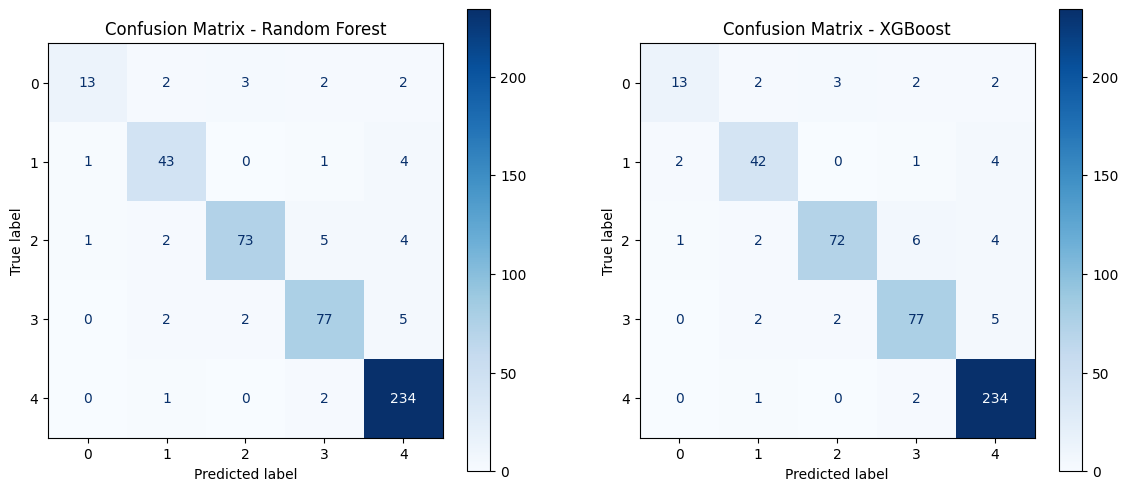

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Refit models with best parameters
best_rf = rf_grid_search.best_estimator_
best_rf.fit(new_X_train, new_y_train)
y_pred_rf = best_rf.predict(new_X_test)

best_xgb = xgb_grid_search.best_estimator_
best_xgb.fit(new_X_train, new_y_train)
y_pred_xgb = best_xgb.predict(new_X_test)

# Plot confusion matrices
plt.figure(figsize=(14, 6))

# Confusion matrix for Random Forest
plt.subplot(1, 2, 1)
cm_rf = confusion_matrix(new_y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf).plot(cmap="Blues", ax=plt.gca())
plt.title("Confusion Matrix - Random Forest")

# Confusion matrix for XGBoost
plt.subplot(1, 2, 2)
cm_xgb = confusion_matrix(new_y_test, y_pred_xgb)
ConfusionMatrixDisplay(cm_xgb).plot(cmap="Blues", ax=plt.gca())
plt.title("Confusion Matrix - XGBoost")

plt.show()


In [ ]:
df
scale = StandardScaler()
X = df.drop(['GradeClass' ,'StudentID','Sports', 'Music'], axis=1)
y = df['GradeClass']
scale.fit_transform(X)

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.2, random_state=123)
X_test , X_CV , y_test , y_CV = train_test_split(X_, y_, test_size=0.5, random_state=123)

In [ ]:
X_CV.describe()

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Volunteering,GPA
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,-0.146390,0.512500,0.979167,0.066249,-0.026621,0.110282,0.345833,0.017454,0.425000,0.141667,-0.083137
std,1.005097,0.500888,1.064639,1.051907,1.021298,1.024609,0.476633,0.989989,0.495376,0.349437,0.994392
min,-1.307132,0.000000,0.000000,-1.745885,-1.728209,-1.717694,0.000000,-1.890357,0.000000,0.000000,-2.070160
25%,-1.307132,0.000000,0.000000,-0.746087,-0.932283,-0.772698,0.000000,-0.999551,0.000000,0.000000,-0.846960
50%,-0.417106,1.000000,1.000000,0.253711,-0.035937,0.172298,0.000000,-0.108744,0.000000,0.000000,-0.137055
75%,0.472919,1.000000,2.000000,0.253711,0.844518,0.999169,1.000000,0.782063,1.000000,0.000000,0.720915
max,1.362944,1.000000,3.000000,2.253308,1.805881,1.707916,1.000000,1.672869,1.000000,1.000000,2.288410


In [ ]:
# Define models
classification_models = {
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier()
}

# Lists to store results
model_names = []
test_accuracies = []
cv_accuracies = []

# Split the data
X_train, X_CV, y_train, y_CV = train_test_split(X, y, test_size=0.2, random_state=42)
X_CV, X_test, y_CV, y_test = train_test_split(X_CV, y_CV, test_size=0.5, random_state=42)

# Train and evaluate each model
for name, clf in classification_models.items():
    clf.fit(X_train, y_train)

    # Accuracy on test set
    y_pred_test = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_accuracies.append(test_accuracy)

    # Cross-validation accuracy
    y_pred_cv = clf.predict(X_CV)
    cv_accuracy = accuracy_score(y_CV, y_pred_cv)
    cv_accuracies.append(cv_accuracy)

    # Store the model name
    model_names.append(name)

    print(f"{name} - Test Accuracy: {test_accuracy:.2f}, Cross-Validation Accuracy: {cv_accuracy:.2f}")

# Create a DataFrame for the accuracies
results_df = pd.DataFrame({
    'Model': model_names,
    'Test Accuracy': test_accuracies,
    'Cross-validation Accuracy': cv_accuracies
})

# Convert accuracies to percentages for the bar plot
results_df['Test Accuracy (%)'] = (results_df['Test Accuracy'] * 100).round(2)
results_df['Cross-validation Accuracy (%)'] = (results_df['Cross-validation Accuracy'] * 100).round(2)

# Plot both Test Accuracy and Cross-validation Accuracy using Plotly
fig = px.bar(results_df, x='Model', y=['Test Accuracy', 'Cross-validation Accuracy'],
             title='Model Test and Cross-Validation Accuracies', barmode='group')

# Customize the text position and format
fig.update_traces(texttemplate='%{value:.2f}', textposition='outside')

# Show the plot
fig.show()

# Display the DataFrame with results
print(results_df)


K-Nearest Neighbors - Test Accuracy: 0.70, Cross-Validation Accuracy: 0.70
Support Vector Machine - Test Accuracy: 0.82, Cross-Validation Accuracy: 0.80
Logistic Regression - Test Accuracy: 0.75, Cross-Validation Accuracy: 0.75
Decision Tree - Test Accuracy: 0.80, Cross-Validation Accuracy: 0.85
Random Forest - Test Accuracy: 0.91, Cross-Validation Accuracy: 0.93
Gradient Boosting - Test Accuracy: 0.89, Cross-Validation Accuracy: 0.92
AdaBoost - Test Accuracy: 0.87, Cross-Validation Accuracy: 0.89
Gaussian Naive Bayes - Test Accuracy: 0.78, Cross-Validation Accuracy: 0.76


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



XGBoost - Test Accuracy: 0.90, Cross-Validation Accuracy: 0.92


                    Model  Test Accuracy  Cross-validation Accuracy  \
0     K-Nearest Neighbors       0.695833                   0.702929   
1  Support Vector Machine       0.816667                   0.803347   
2     Logistic Regression       0.750000                   0.753138   
3           Decision Tree       0.795833                   0.849372   
4           Random Forest       0.912500                   0.928870   
5       Gradient Boosting       0.891667                   0.916318   
6                AdaBoost       0.866667                   0.887029   
7    Gaussian Naive Bayes       0.775000                   0.761506   
8                 XGBoost       0.895833                   0.920502   

   Test Accuracy (%)  Cross-validation Accuracy (%)  
0              69.58                          70.29  
1              81.67                          80.33  
2              75.00                          75.31  
3              79.58                          84.94  
4              91.2